In [3]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os

In [4]:
# Reading the directory - Train and Validation Set

train_pneumonia_data = os.path.join('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA')
train_normal_data = os.path.join('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL')

test_pneumonia_data = os.path.join('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA')
test_normal_data = os.path.join('/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL')

In [5]:
# Lets look at the images in train dataset

train_pneumonia_names = os.listdir(train_pneumonia_data)

print(train_pneumonia_names[:10])

train_normal_names = os.listdir(train_normal_data)

print(train_normal_names[:10])

['person957_virus_1629.jpeg', 'person1372_bacteria_3498.jpeg', 'person1284_bacteria_3247.jpeg', 'person439_virus_891.jpeg', 'person501_bacteria_2113.jpeg', 'person1559_bacteria_4067.jpeg', 'person1001_bacteria_2932.jpeg', 'person739_virus_1361.jpeg', 'person1644_bacteria_4357.jpeg', 'person537_bacteria_2261.jpeg']
['IM-0242-0001.jpeg', 'NORMAL2-IM-1047-0001.jpeg', 'NORMAL2-IM-0553-0001.jpeg', 'NORMAL2-IM-0578-0001.jpeg', 'NORMAL2-IM-0945-0001.jpeg', 'NORMAL2-IM-0520-0001.jpeg', 'NORMAL2-IM-1291-0001.jpeg', 'NORMAL2-IM-0871-0001.jpeg', 'IM-0533-0001.jpeg', 'NORMAL2-IM-1142-0001.jpeg']


In [6]:
print('Total training Pneumonia detected images:', len(os.listdir(train_pneumonia_data)))
print('Total training Normal detected images:', len(os.listdir(train_normal_data)))

Total training Pneumonia detected images: 3875
Total training Normal detected images: 1341


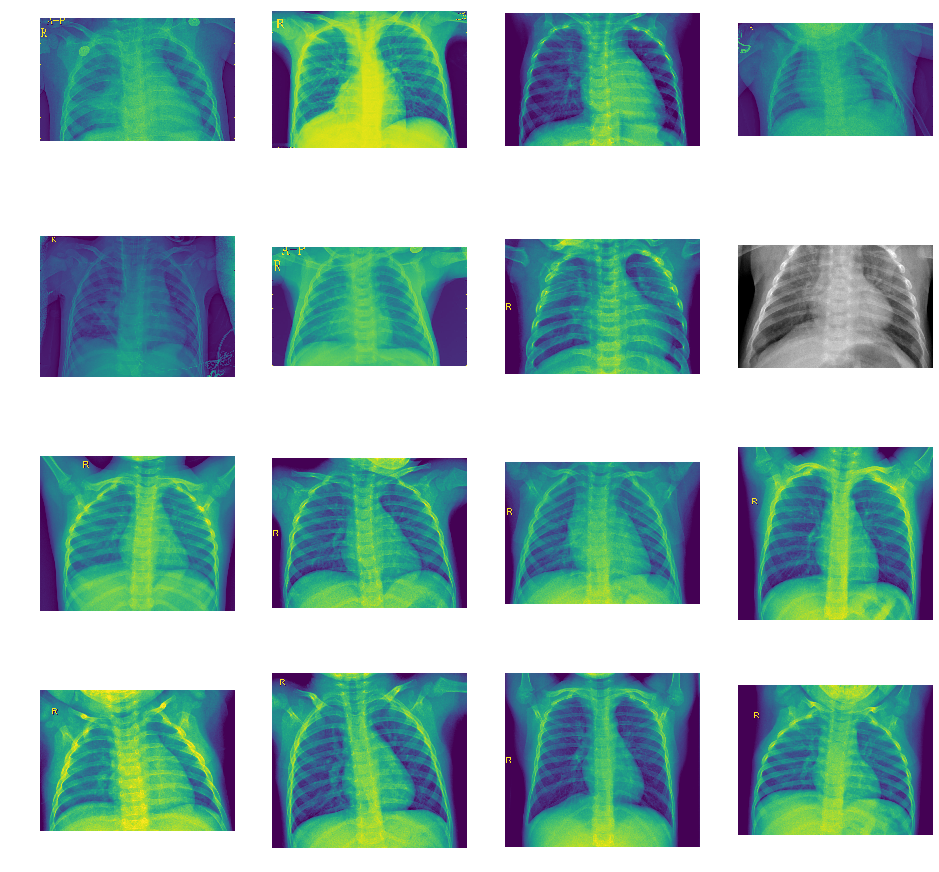

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_pn_pix = [os.path.join(train_pneumonia_data, fname) 
                for fname in train_pneumonia_names[pic_index-8:pic_index]]
next_normal_pix = [os.path.join(train_normal_data, fname) 
                for fname in train_normal_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_pn_pix+next_normal_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [9]:
import cv2
import glob
all_h = []
all_w = []
for img in glob.glob("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*"):
    n= cv2.imread(img)
    h, w, _ = n.shape
    all_h.append(h)
    all_w.append(w)

In [10]:
print('Average Height of the Train Data:', np.average(all_h))
print('Average Width of the Train data:' , np.average(all_w))

Average Height of the Train Data: 825.0268387096775
Average Width of the Train data: 1200.4836129032258


In [11]:
# Model Building:

model = tf.keras.models.Sequential( [
    # First Convolution
    tf.keras.layers.Conv2D(16 , (3,3) , activation = 'relu' , input_shape = (825,1200,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # Second Convolution
    tf.keras.layers.Conv2D(4, (3,3) , activation = 'relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # Flatten the images
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(0.2),
    tf.keras.layers.Dense(1 , activation = 'sigmoid')
]    
)

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 823, 1198, 16)     448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 411, 599, 16)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 411, 599, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 409, 597, 4)       580       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 204, 298, 4)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 204, 298, 4)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 243168)           

In [14]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss= 'binary_crossentropy' , optimizer= RMSprop(lr = 0.05) , metrics= ['acc'])

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1/255)

In [16]:
train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/chest-xray-pneumonia/chest_xray/train/',  # This is the source directory for training images
        target_size=(825, 1200),  # All images will be resized to 150x150
        #batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
test_generator = test_datagen.flow_from_directory(
        '/kaggle/input/chest-xray-pneumonia/chest_xray/test/',  # This is the source directory for training images
        target_size=(825, 1200),  # All images will be resized to 150x150
        #batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=20,
      verbose=1,
      validation_data = test_generator,
      validation_steps=2)

Train for 8 steps, validate for 2 steps
Epoch 1/20
8/8 [==============================] - 14s 2s/step - loss: 0.5884 - acc: 0.7266 - val_loss: 0.7044 - val_acc: 0.6094
Epoch 2/20
8/8 [==============================] - 15s 2s/step - loss: 0.6058 - acc: 0.7070 - val_loss: 0.6904 - val_acc: 0.6094
Epoch 3/20
8/8 [==============================] - 16s 2s/step - loss: 0.5726 - acc: 0.7422 - val_loss: 0.7097 - val_acc: 0.6094
Epoch 4/20
8/8 [==============================] - 16s 2s/step - loss: 0.5720 - acc: 0.7422 - val_loss: 0.7092 - val_acc: 0.6094
Epoch 5/20
8/8 [==============================] - 15s 2s/step - loss: 0.5599 - acc: 0.7539 - val_loss: 0.7151 - val_acc: 0.6094
Epoch 6/20
8/8 [==============================] - 15s 2s/step - loss: 0.5848 - acc: 0.7305 - val_loss: 0.7111 - val_acc: 0.6094
Epoch 7/20
8/8 [==============================] - 15s 2s/step - loss: 0.5765 - acc: 0.7383 - val_loss: 0.7083 - val_acc: 0.6094
Epoch 8/20
8/8 [==============================] - 16s 2s/step - 

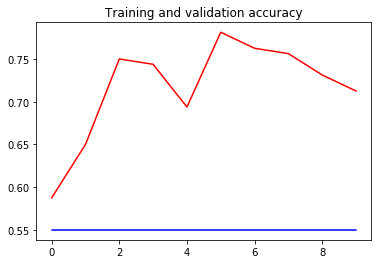

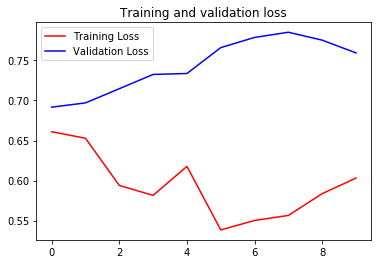

In [18]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()